In [1]:
import os
import sys
import torch
from timeit import default_timer as timer
from datetime import timedelta

BASE_DIR = os.path.dirname('./')
ROOT_DIR = os.path.dirname(BASE_DIR)
sys.path.append(ROOT_DIR)

import yaml

from lib.common.helpers.dataloader_helper import build_dataset
from lib.common.helpers.model_helper import build_model
from lib.common.helpers.visualization_helper import visualization
from lib.common.helpers.print_helper import PrintHelper
from lib.common.helpers.multi_processor_helper import compareAll
from lib.common.helpers.multi_processor_helper import average_lists

In [2]:
mode = 'val' # test, eval, train
config = 'configs/kitti-multi.yaml'
from lib.monoDTR.printer import Printer as PrinterDTR
from lib.monoLSS.printer import Printer as PrinterLSS

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# load cfg
assert (os.path.exists(config))
cfg = yaml.load(open(config, 'r'), Loader=yaml.Loader)
  
#  build dataloader
dataset = build_dataset(cfg['dataset'], mode)


printHelper = PrintHelper(dataset)


MonoDTR = PrinterDTR(cfg['MonoDTR'], build_model(cfg['MonoDTR']))
MonoLSS = PrinterLSS(cfg['MonoLSS'], build_model(cfg['MonoLSS']))


Using device: cuda


In [3]:
idx = 0


11
közös: 


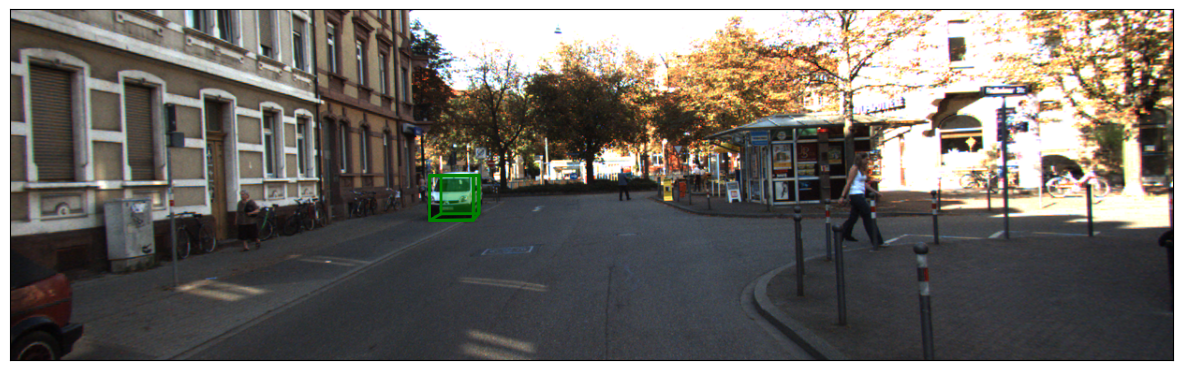

MonoLSS: 


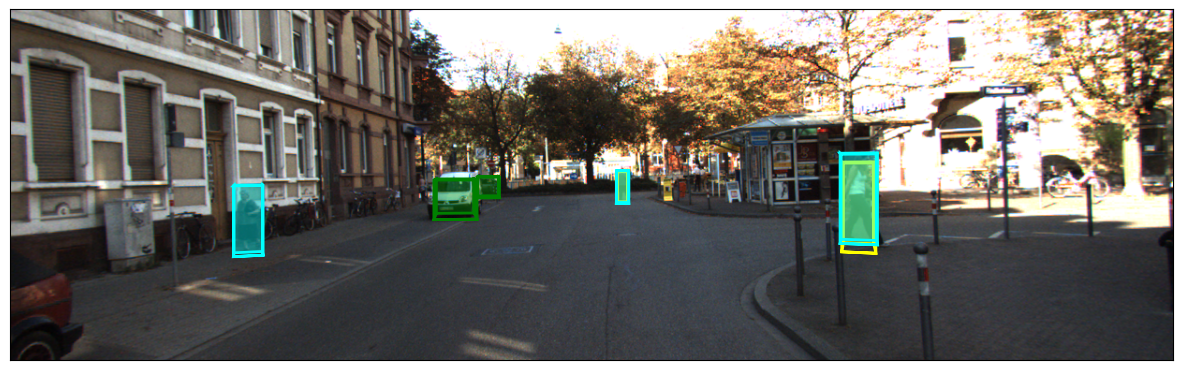

MonoDTR: 


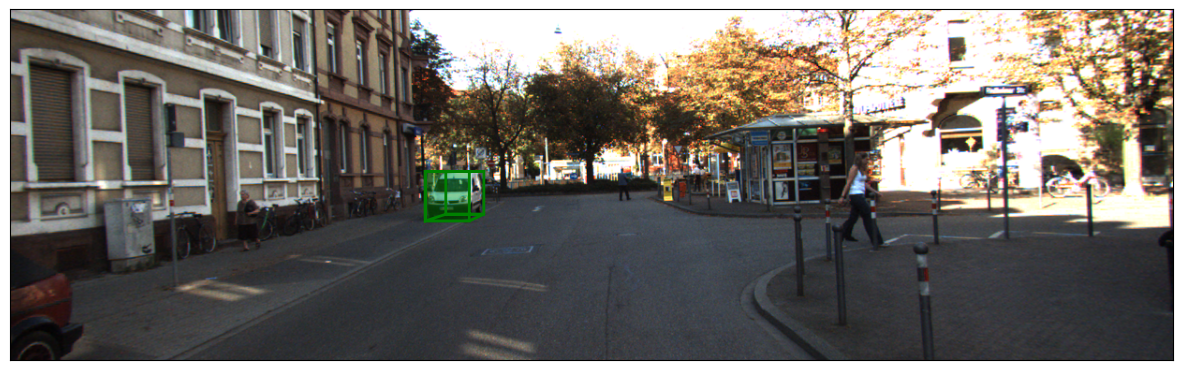

In [15]:
print(idx)

for x in range(1):
    img, calibs = printHelper.getPrintables(idx)
    
    torch.cuda.synchronize() # Wait for all kernels in all streams on a CUDA device to complete.
    start_time = timer()

    predsDTR = MonoDTR.print(img, calibs, 0.8)
    predsLSS = MonoLSS.print(img, calibs, 0.2)

    torch.cuda.synchronize() # Wait for all kernels in all streams on a CUDA device to complete.
    end_time = timer()
    #print(timedelta(seconds=end_time - start_time))
    
    same = compareAll(predsDTR,predsLSS)
    resultsLSS = []
    resultsDTR = []
    for dtr_idx, lss_idx in same:
        resultsLSS.append(predsLSS[lss_idx])
        resultsDTR.append(predsDTR[dtr_idx])

    result = average_lists(resultsLSS, resultsDTR)

    print('közös: ')
    #print(result)
    #print(resultsLSS)
    #print(resultsDTR)
    visualization(img, calibs, result, True, False, False)

    print('MonoLSS: ')
    #print(resultsLSS)
    visualization(img, calibs, predsLSS, True, False, False)
    #visualization(img, calibs, resultsLSS, True, False, False)

    print('MonoDTR: ')
    #print(resultsDTR)
    visualization(img, calibs, predsDTR, True, False, False)
    #visualization(img, calibs, resultsDTR, True, False, False)

    idx = idx +1